[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP211/2023-fall-class-notebooks/blob/main/in-class/galilee.ipynb)

In [2]:
%load_ext autoreload
%autoreload 2
import sys

! pip install  "sep_plot @ git+https://github.com/SEP-software/sep-plot.git@12552d6c6e452b7f22d6e4abc51af2a6f3d7b486" 
import generic_solver


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
! wget https://github.com/GP211/2023-fall-class-notebooks/raw/main/data/galilee.H

In [3]:
from sep_python import default_io
vec=default_io.vector_from_storage("./galilee.H")

In [4]:
print(vec)

FloatVector
Axis 1: n=3	o=0.0	d=1.0
Axis 2: n=132044	o=0.0	d=1.0



In [5]:
import copy
from generic_solver._pyOperator import Operator
class bin_2d(Operator):

    def __init__(self,mod,dat,xy):
        super().__init__(mod,dat)
        hyper=mod.get_hyper()
        ax=hyper.axes[0]
        n1,o1,d1=ax.n,ax.o,ax.d
        ax=hyper.axes[1]
        n2,o2,d2=ax.n,ax.o,ax.d
        self._i1=np.zeros(xy.shape[1],dtype=np.int32)
        self._i2=np.zeros(xy.shape[1],dtype=np.int32)
        self._sc=np.ones(xy.shape[1])
        for i in range(self._i1.shape[0]):
            self._i1[i]=(xy[0,i]-o1)/d1+.5
            self._i2[i]=(xy[1,i]-o2)/d2+.5
            if self._i1[i] < 0 or self._i2[i] < 0 or self._i1[i] >=n1 or self._i2[i]>=n2:
                self._i1[i]=0
                self._i2[i]=0
                self._sc[i]=0
    def forward(self,add,mod,dat):
        self.checkDomainRange(mod,dat)
        if not add: dat.zero()
        d=dat.get_nd_array()
        m=mod.get_nd_array()
        for i in range(self._i1.shape[0]):
            d[i]+=sc[i]*m[self._i1[i],self._i2[i]]


    def adjoint(self,add,mod,dat):
        self.checkDomainRange(mod,dat)
        if not add: mod.zero()
     #   for i1,i2,d,sc in zip(self._i1,self._i2,dat,self._sc):
     #       mod[i1,i2]+=sc*d
        for i in range(self._i1.shape[0]):
            mod[self._i1[i],self._i2[i]]=self._sc[i]*dat[i]
        m=mod.get_nd_array()


## Find the range of x,y 

In [6]:
xyz=vec.get_nd_array()
x=xyz[:,0]
y=xyz[:,1]
z=xyz[:,2]
print(f"range of x : {x.min()} - {x.max()}")
print(f"range of y : {y.min()} - {y.max()}")
print(f"range of z : {z.min()} - {z.max()}")

range of x : 198.78199768066406 - 212.78900146484375
range of y : 234.70199584960938 - 255.552001953125
range of z : -256.45001220703125 - 0.0


## Define our regular grid

In [7]:
n1=200
n2=200
o1=198
o2=234
d1=(213-o1)/n1
d2=(256-234)/n2

## Create our model space

In [8]:
from sep_python import Axis,Hypercube, get_sep_vector
ax1=Axis(n=n1,o=o1,d=d1)
ax2=Axis(n=n2,o=o2,d=d2)
hyper=Hypercube([ax1,ax2])
mod=get_sep_vector(hyper)

In [9]:
# Create our data 

In [10]:
dat=get_sep_vector(z)

# Hessian approximation 
Create a function that approximates the inverse hessian 

In [11]:
def diagonal_approx(oper):
    dat=oper.range.clone()
    mod=oper.domain.clone()
    mod.zero()
    dat[:]=1
    oper.adjoint(False,mod,dat)
    return np.where(mod.get_nd_array() !=0, 1./mod.get_nd_array(), 0)


## Form our operator

In [12]:
import numpy as np
xy=np.vstack((x,y))
bin_op=bin_2d(mod,dat,xy)

In [13]:
## Approximate the inverse

In [14]:
mprime=mod.clone()
bin_op.adjoint(False, mprime,dat)
approx=diagonal_approx(bin_op)
mod[:,:]=mprime[:,:]*approx[:,:]

/var/folders/69/z1qrsb455x90d4pvp67r4ccr00lgnl/T/ipykernel_48522/542785970.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.where(mod.get_nd_array() !=0, 1./mod.get_nd_array(), 0)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
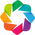

:Image   [x,y]   (z)

In [15]:
import sep_plot
sep_plot.Grey(mod,bclip=-250 ,eclip=-200,invert_yaxis=False)